# Adding variables to model: Contract Subjects version

In [146]:
import pandas as pd
import ETL as etl
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Parameters
SECOPI_PROCESS_API = 'f789-7hwg'
SECOPII_PROCESS_API = 'jbjy-vk9h'
SECOPI_ADDITIONS_API = '7fix-nd37'
SECOPI_PUNISHMENT_API = '4n4q-k399'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [147]:
# General functions
import os

# Get query files function
def get_path(folder, file_path):
    current_directory = os.getcwd()
    return os.path.join(current_directory, '..', folder, file_path)


def get_query(folder, file_path):
    path = get_path(folder, file_path)
    # try to get the query
    with open(path, "r", encoding="utf8") as query_file:
        query = query_file.read()
    
    return query

def parse_to_list(ls):
    ids = [ str(i) for i in ls]
    ids = "'" + "','".join(ids) + "'"
    return ids

## Set Up

In [148]:
procesos_data = pd.read_csv(get_path('data', 'collected_vias_rurales_data.csv'),
                 dtype = {'ID_ADJUDICACION': str},
                 parse_dates=['START_DATE','CONTRACT_DATE'])

procesos_secop_i_data = procesos_data[-procesos_data['GROUP'].str.contains('SECOP II')].copy()

procesos_secop_i_data['HAVE_DEVIATION'] = (procesos_secop_i_data['COST_DEVIATION_NORM']  > 0) | (procesos_secop_i_data['TIME_DEVIATION'] > 0)
procesos_secop_i_data['HAVE_DEVIATION_COST'] = procesos_secop_i_data['COST_DEVIATION_NORM']  > 0
procesos_secop_i_data['HAVE_DEVIATION_TIME'] = procesos_secop_i_data['TIME_DEVIATION']  > 0

#Summary
def summary(x):
    data = {}

    data['unique contracts'] = x['CONTRACT_ID'].size
    data['value norm avg'] = x['CONTRACT_VALUE_NORM'].mean()
    data['cost deviation (%)'] = x['COST_DEVIATION_NORM'].mean()*100
    data['time duration avg'] = x['ORIGINAL_DEADLINE'].mean()
    data['time deviation (%)'] = x['TIME_DEVIATION'].mean()*100
    #data['Project intensity norm avg'] = x['PROJECT_INTENSITY_NORM'].mean()

    return pd.Series(data)

# Impression
variables = ['HAVE_DEVIATION_COST','HAVE_DEVIATION_TIME']
procesos_secop_i_data.groupby(variables)[variables].size()
procesos_secop_i_data.groupby(variables).apply(summary)

unique contracts  value norm avg  \
HAVE_DEVIATION_COST HAVE_DEVIATION_TIME                                     
False               False                            97.0     1881.950384   
                    True                             22.0     1784.202816   
True                False                            11.0      792.193718   
                    True                             37.0     2429.958294   

                                         cost deviation (%)  \
HAVE_DEVIATION_COST HAVE_DEVIATION_TIME                       
False               False                          0.000000   
                    True                           0.000000   
True                False                         18.526972   
                    True                          23.790388   

                                         time duration avg  time deviation (%)  
HAVE_DEVIATION_COST HAVE_DEVIATION_TIME                                         
False               False                       107.216495            0.000000  
                    True                        109.727273           74.254723  
True                False                       102.272727            0.000000  
                    True                        119.864865           80.484234

In [149]:
def class_project(row):
    if row['HAVE_DEVIATION_COST'] and row['HAVE_DEVIATION_TIME']:
        return 'Both deviation'
    elif row['HAVE_DEVIATION_COST'] and not row['HAVE_DEVIATION_TIME']:
        return 'Only cost deviation'
    elif not row['HAVE_DEVIATION_COST'] and row['HAVE_DEVIATION_TIME']:
        return 'Only time deviation'
    else:
        return 'Neither'

# Apply the function to each row
procesos_secop_i_data['DEVIATION_TYPE'] = procesos_secop_i_data.apply(class_project, axis=1)

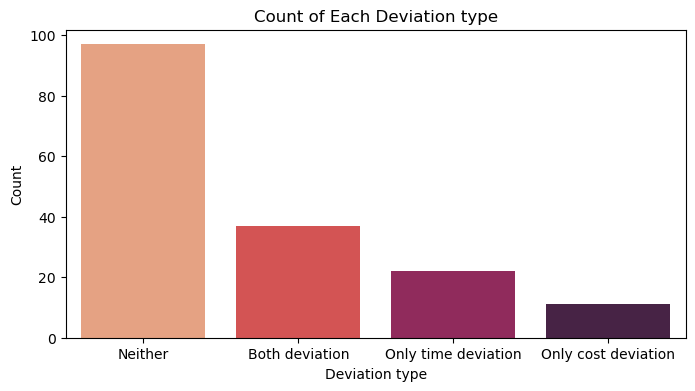

In [150]:
# Create the histogram plot
sorted_counts = procesos_secop_i_data['DEVIATION_TYPE'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.countplot(data=procesos_secop_i_data, 
              x='DEVIATION_TYPE', 
              order=sorted_counts.index,
              palette='rocket_r')
plt.title('Count of Each Deviation type')
plt.xlabel('Deviation type')
plt.ylabel('Count')
plt.show()

c:\Users\nicolas.arrieta\anaconda3\envs\hospital_procurement_data\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


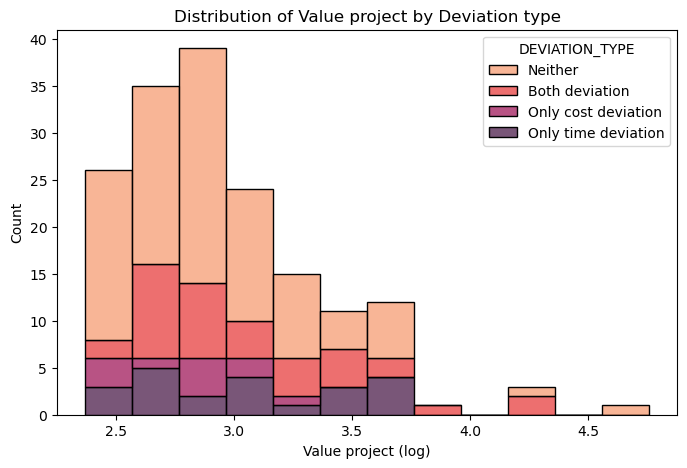

In [182]:
procesos_secop_i_data['CONTRACT_VALUE_LOGNORM'] = np.log10(procesos_secop_i_data['CONTRACT_VALUE_NORM'])

plt.figure(figsize=(8, 5))
sns.histplot(data=procesos_secop_i_data, 
             x='CONTRACT_VALUE_LOGNORM', 
             hue='DEVIATION_TYPE', 
             multiple='stack', palette='rocket_r', bins=12)

plt.title('Distribution of Value project by Deviation type')
plt.xlabel('Value project (log)')
#plt.legend(title='Deviation type'
           #, labels=procesos_secop_i_data['DEVIATION_TYPE'].value_counts().index
 #          )
plt.ylabel('Count')
plt.show()

c:\Users\nicolas.arrieta\anaconda3\envs\hospital_procurement_data\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


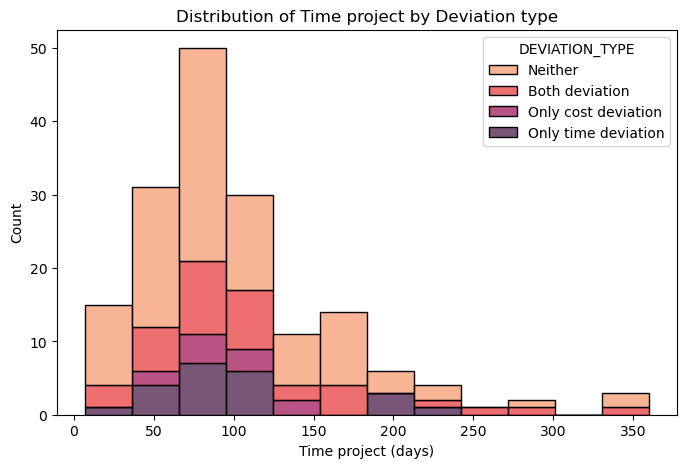

In [183]:
plt.figure(figsize=(8, 5))
sns.histplot(data=procesos_secop_i_data, 
             x='ORIGINAL_DEADLINE', 
             hue='DEVIATION_TYPE', 
             multiple='stack', palette='rocket_r', bins=12)

plt.title('Distribution of Time project by Deviation type')
plt.xlabel('Time project (days)')
# plt.legend(title='Deviation type', labels=procesos_secop_i_data['DEVIATION_TYPE'].value_counts().index)
plt.ylabel('Count')
plt.show()

## Entity dimentions
### Municipality Type breakdown

* The 5 & 6 type are the unique categories where the adition projects is under 50%
* The other category has the highest value average project, but seems a missing data because the principal departments are incluided there (Bogotá, Antioquia, etc)

In [153]:
procesos_secop_i_data.groupby(['MUNICIPALITY_TYPE', 'HAVE_DEVIATION']).apply(summary)

unique contracts  value norm avg  \
MUNICIPALITY_TYPE HAVE_DEVIATION                                     
OTHER             False                        9.0     3987.236766   
                  True                         4.0     6180.372166   
TYPE_1            True                         1.0     2708.430242   
TYPE_2            False                        7.0      732.473664   
                  True                         3.0     1536.283323   
TYPE_3            False                        1.0     1436.342120   
                  True                         3.0     1385.343414   
TYPE_4            False                        2.0      788.720881   
                  True                         3.0      650.357908   
TYPE_5            False                        6.0      958.016795   
                  True                         9.0     4500.803783   
TYPE_6            False                       72.0     1844.095223   
                  True                        47.0     1260.041337   

                                  cost deviation (%)  time duration avg  \
MUNICIPALITY_TYPE HAVE_DEVIATION                                          
OTHER             False                     0.000000         150.222222   
                  True                     19.583405         142.500000   
TYPE_1            True                     49.958475          90.000000   
TYPE_2            False                     0.000000          89.000000   
                  True                      8.634974         115.000000   
TYPE_3            False                     0.000000         180.000000   
                  True                     21.839863          95.000000   
TYPE_4            False                     0.000000          70.000000   
                  True                     16.545860          80.000000   
TYPE_5            False                     0.000000          62.500000   
                  True                     35.284131         161.666667   
TYPE_6            False                     0.000000         107.361111   
                  True                     10.577227         106.148936   

                                  time deviation (%)  
MUNICIPALITY_TYPE HAVE_DEVIATION                      
OTHER             False                     0.000000  
                  True                    146.736111  
TYPE_1            True                    200.000000  
TYPE_2            False                     0.000000  
                  True                      7.142857  
TYPE_3            False                     0.000000  
                  True                     49.074074  
TYPE_4            False                     0.000000  
                  True                     64.444444  
TYPE_5            False                     0.000000  
                  True                     74.334215  
TYPE_6            False                     0.000000  
                  True                     59.437959

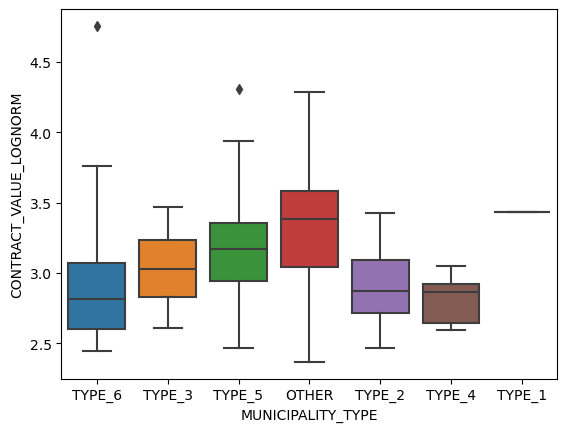

In [154]:
sns.boxplot(x="MUNICIPALITY_TYPE", y="CONTRACT_VALUE_LOGNORM", data=procesos_secop_i_data)
plt.show()

In [155]:
from scipy.stats import kruskal

def kruskal_test(data, groups, values):
    groups = data.groupby(groups)[values].apply(list)

    stat, p = kruskal(*groups)

    # Print the results
    print(f"Kruskal-Wallis H-statistic: {stat}")
    print(f"p-value: {p}")

print('Value project')
kruskal_test(procesos_secop_i_data, 'MUNICIPALITY_TYPE', 'CONTRACT_VALUE_LOGNORM')

print('Time durantion project')
kruskal_test(procesos_secop_i_data, 'MUNICIPALITY_TYPE', 'ORIGINAL_DEADLINE')

Value project
Kruskal-Wallis H-statistic: 16.53888791313107
p-value: 0.011135988922630666
Time durantion project
Kruskal-Wallis H-statistic: 2.724744297594981
p-value: 0.8425159533521364


#### Detail for each adition type

In [156]:
procesos_secop_i_data.groupby(['MUNICIPALITY_TYPE', 'HAVE_DEVIATION_COST']).apply(summary)

unique contracts  value norm avg  \
MUNICIPALITY_TYPE HAVE_DEVIATION_COST                                     
OTHER             False                            11.0     3707.613467   
                  True                              2.0     9911.435710   
TYPE_1            True                              1.0     2708.430242   
TYPE_2            False                             9.0      932.494555   
                  True                              1.0     1343.714624   
TYPE_3            False                             1.0     1436.342120   
                  True                              3.0     1385.343414   
TYPE_4            False                             4.0      783.706919   
                  True                              1.0      393.687810   
TYPE_5            False                             7.0     1199.521962   
                  True                              8.0     4732.335135   
TYPE_6            False                            87.0     1835.145132   
                  True                             32.0     1010.599136   

                                       cost deviation (%)  time duration avg  \
MUNICIPALITY_TYPE HAVE_DEVIATION_COST                                          
OTHER             False                          0.000000         136.545455   
                  True                          39.166810         210.000000   
TYPE_1            True                          49.958475          90.000000   
TYPE_2            False                          0.000000         102.555556   
                  True                          25.904922          45.000000   
TYPE_3            False                          0.000000         180.000000   
                  True                          21.839863          95.000000   
TYPE_4            False                          0.000000          83.750000   
                  True                          49.637581          45.000000   
TYPE_5            False                          0.000000          68.571429   
                  True                          39.694648         168.750000   
TYPE_6            False                          0.000000         107.977011   
                  True                          15.535302         103.906250   

                                       time deviation (%)  
MUNICIPALITY_TYPE HAVE_DEVIATION_COST                      
OTHER             False                         40.404040  
                  True                          71.250000  
TYPE_1            True                         200.000000  
TYPE_2            False                          2.380952  
                  True                           0.000000  
TYPE_3            False                          0.000000  
                  True                          49.074074  
TYPE_4            False                         31.666667  
                  True                          66.666667  
TYPE_5            False                          2.040816  
                  True                          81.840278  
TYPE_6            False                         11.802052  
                  True                          55.212674

In [157]:
procesos_secop_i_data.groupby(['MUNICIPALITY_TYPE', 'HAVE_DEVIATION_TIME']).apply(summary)

unique contracts  value norm avg  \
MUNICIPALITY_TYPE HAVE_DEVIATION_TIME                                     
OTHER             False                             9.0     3987.236766   
                  True                              4.0     6180.372166   
TYPE_1            True                              1.0     2708.430242   
TYPE_2            False                             8.0      808.878784   
                  True                              2.0     1632.567673   
TYPE_3            False                             1.0     1436.342120   
                  True                              3.0     1385.343414   
TYPE_4            False                             2.0      788.720881   
                  True                              3.0      650.357908   
TYPE_5            False                             7.0     1032.358621   
                  True                              8.0     4878.603059   
TYPE_6            False                            81.0     1711.936577   
                  True                             38.0     1403.419372   

                                       cost deviation (%)  time duration avg  \
MUNICIPALITY_TYPE HAVE_DEVIATION_TIME                                          
OTHER             False                          0.000000         150.222222   
                  True                          19.583405         142.500000   
TYPE_1            True                          49.958475          90.000000   
TYPE_2            False                          3.238115          83.500000   
                  True                           0.000000         150.000000   
TYPE_3            False                          0.000000         180.000000   
                  True                          21.839863          95.000000   
TYPE_4            False                          0.000000          70.000000   
                  True                          16.545860          80.000000   
TYPE_5            False                          4.289569          75.000000   
                  True                          35.941275         163.125000   
TYPE_6            False                          1.825491         106.913580   
                  True                           9.191181         106.815789   

                                       time deviation (%)  
MUNICIPALITY_TYPE HAVE_DEVIATION_TIME                      
OTHER             False                          0.000000  
                  True                         146.736111  
TYPE_1            True                         200.000000  
TYPE_2            False                          0.000000  
                  True                          10.714286  
TYPE_3            False                          0.000000  
                  True                          49.074074  
TYPE_4            False                          0.000000  
                  True                          64.444444  
TYPE_5            False                          0.000000  
                  True                          83.625992  
TYPE_6            False                          0.000000  
                  True                          73.515370

### Region breakdown
* The Andina region shows the most differents in the value of contrats and has the major number of projects
* The orinoquia have the inverse case of the region above

In [158]:
procesos_secop_i_data.groupby(['REGION', 'HAVE_DEVIATION']).apply(summary)

unique contracts  value norm avg  \
REGION    HAVE_DEVIATION                                     
AMAZONIA  False                        4.0     2215.495746   
          True                         1.0     4209.237337   
ANDINA    False                       76.0     1793.061989   
          True                        52.0     2082.491011   
CARIBE    False                        4.0      793.063340   
          True                         3.0      817.052519   
ORINOQUIA False                        6.0     4473.198745   
          True                        11.0     1642.577028   
PACIFICA  False                        7.0     1057.578177   
          True                         3.0     1618.924977   

                          cost deviation (%)  time duration avg  \
REGION    HAVE_DEVIATION                                          
AMAZONIA  False                     0.000000         180.000000   
          True                     18.326741         240.000000   
ANDINA    False                     0.000000         102.605263   
          True                     15.342526         110.653846   
CARIBE    False                     0.000000          82.500000   
          True                     40.484453          50.000000   
ORINOQUIA False                     0.000000         117.500000   
          True                     13.313601         120.000000   
PACIFICA  False                     0.000000         121.000000   
          True                      0.000000         170.000000   

                          time deviation (%)  
REGION    HAVE_DEVIATION                      
AMAZONIA  False                     0.000000  
          True                     87.500000  
ANDINA    False                     0.000000  
          True                     73.515200  
CARIBE    False                     0.000000  
          True                     77.777778  
ORINOQUIA False                     0.000000  
          True                     34.455267  
PACIFICA  False                     0.000000  
          True                     29.629630

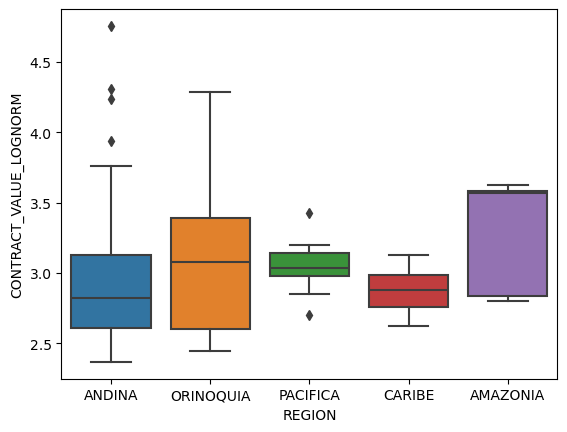

In [159]:
sns.boxplot(x="REGION", y="CONTRACT_VALUE_LOGNORM", data=procesos_secop_i_data)
plt.show()

#### Detail for each adition type

In [160]:
procesos_secop_i_data.groupby(['REGION', 'HAVE_DEVIATION_COST']).apply(summary)

unique contracts  value norm avg  \
REGION    HAVE_DEVIATION_COST                                     
AMAZONIA  False                             4.0     2215.495746   
          True                              1.0     4209.237337   
ANDINA    False                            92.0     1809.374558   
          True                             36.0     2169.438457   
CARIBE    False                             4.0      793.063340   
          True                              3.0      817.052519   
ORINOQUIA False                             9.0     3449.459039   
          True                              8.0     1732.801053   
PACIFICA  False                            10.0     1225.982217   

                               cost deviation (%)  time duration avg  \
REGION    HAVE_DEVIATION_COST                                          
AMAZONIA  False                          0.000000         180.000000   
          True                          18.326741         240.000000   
ANDINA    False                          0.000000         102.195652   
          True                          22.161426         115.277778   
CARIBE    False                          0.000000          82.500000   
          True                          40.484453          50.000000   
ORINOQUIA False                          0.000000         111.666667   
          True                          18.306202         127.500000   
PACIFICA  False                          0.000000         135.700000   

                               time deviation (%)  
REGION    HAVE_DEVIATION_COST                      
AMAZONIA  False                          0.000000  
          True                          87.500000  
ANDINA    False                         15.258289  
          True                          67.195216  
CARIBE    False                          0.000000  
          True                          77.777778  
ORINOQUIA False                         15.661376  
          True                          29.756944  
PACIFICA  False                          8.888889

In [161]:
procesos_secop_i_data.groupby(['REGION', 'HAVE_DEVIATION_TIME']).apply(summary)

unique contracts  value norm avg  \
REGION    HAVE_DEVIATION_TIME                                     
AMAZONIA  False                             4.0     2215.495746   
          True                              1.0     4209.237337   
ANDINA    False                            85.0     1672.526093   
          True                             43.0     2381.337812   
CARIBE    False                             5.0      903.193597   
          True                              2.0      553.721467   
ORINOQUIA False                             7.0     4045.371721   
          True                             10.0     1658.993773   
PACIFICA  False                             7.0     1057.578177   
          True                              3.0     1618.924977   

                               cost deviation (%)  time duration avg  \
REGION    HAVE_DEVIATION_TIME                                          
AMAZONIA  False                          0.000000         180.000000   
          True                          18.326741         240.000000   
ANDINA    False                          1.739586         102.682353   
          True                          15.115036         112.186047   
CARIBE    False                          5.180984          75.000000   
          True                          47.774218          52.500000   
ORINOQUIA False                          4.289569         122.142857   
          True                          11.642263         117.000000   
PACIFICA  False                          0.000000         121.000000   
          True                           0.000000         170.000000   

                               time deviation (%)  
REGION    HAVE_DEVIATION_TIME                      
AMAZONIA  False                          0.000000  
          True                          87.500000  
ANDINA    False                          0.000000  
          True                          88.902102  
CARIBE    False                          0.000000  
          True                         116.666667  
ORINOQUIA False                          0.000000  
          True                          37.900794  
PACIFICA  False                          0.000000  
          True                          29.629630

### Started Year breakdown

In [162]:
procesos_secop_i_data.groupby(['YEAR', 'HAVE_DEVIATION']).apply(summary)

unique contracts  value norm avg  cost deviation (%)  \
YEAR HAVE_DEVIATION                                                         
2015 False                       26.0     1774.964757            0.000000   
     True                        10.0     1963.285280           12.321938   
2016 False                        7.0      916.960896            0.000000   
     True                        11.0     2763.630570           30.786042   
2017 False                       14.0      508.725798            0.000000   
     True                         9.0     2890.238625           15.147353   
2018 False                       18.0     1295.968065            0.000000   
     True                        13.0     1719.406069           20.711114   
2019 False                       16.0     1818.431239            0.000000   
     True                        15.0     1836.436893            8.424204   
2020 False                        4.0      869.094777            0.000000   
     True                         4.0     1156.862755            5.530047   
2021 False                        8.0     7895.846442            0.000000   
     True                         4.0      667.968941           10.196715   
2022 False                        2.0     1400.688547            0.000000   
     True                         4.0     1157.988487            6.833607   
2023 False                        2.0      496.181689            0.000000   

                     time duration avg  time deviation (%)  
YEAR HAVE_DEVIATION                                         
2015 False                   91.346154            0.000000  
     True                   101.000000           71.944444  
2016 False                   92.142857            0.000000  
     True                    99.545455           66.111111  
2017 False                   81.785714            0.000000  
     True                   105.000000           74.982363  
2018 False                  140.000000            0.000000  
     True                   124.615385           68.311966  
2019 False                  142.562500            0.000000  
     True                   124.666667           63.935185  
2020 False                   73.750000            0.000000  
     True                   144.750000           62.319625  
2021 False                   88.125000            0.000000  
     True                    71.250000           81.111111  
2022 False                  150.000000            0.000000  
     True                   142.500000           17.301587  
2023 False                   67.000000            0.000000

In [163]:
procesos_secop_i_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   CONTRACT_ID             167 non-null    object        
 1   ENTITY_NAME             167 non-null    object        
 2   DEPARTMENT              167 non-null    object        
 3   MUNICIPALITY_TYPE       167 non-null    object        
 4   PROCESS_TYPE            167 non-null    object        
 5   CONTRACT_OBJECT         167 non-null    object        
 6   OBJETC_DETAIL           167 non-null    object        
 7   ESTIMATED_COST_ORIG     167 non-null    float64       
 8   CONTRACT_VALUE_ORIG     167 non-null    float64       
 9   ADDITIONAL_COST_ORIG    167 non-null    float64       
 10  FINAL_COST_ORIG         167 non-null    float64       
 11  YEAR                    167 non-null    int64         
 12  CONTRACT_DATE           167 non-null    datetime64

c:\Users\nicolas.arrieta\anaconda3\envs\hospital_procurement_data\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nicolas.arrieta\anaconda3\envs\hospital_procurement_data\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


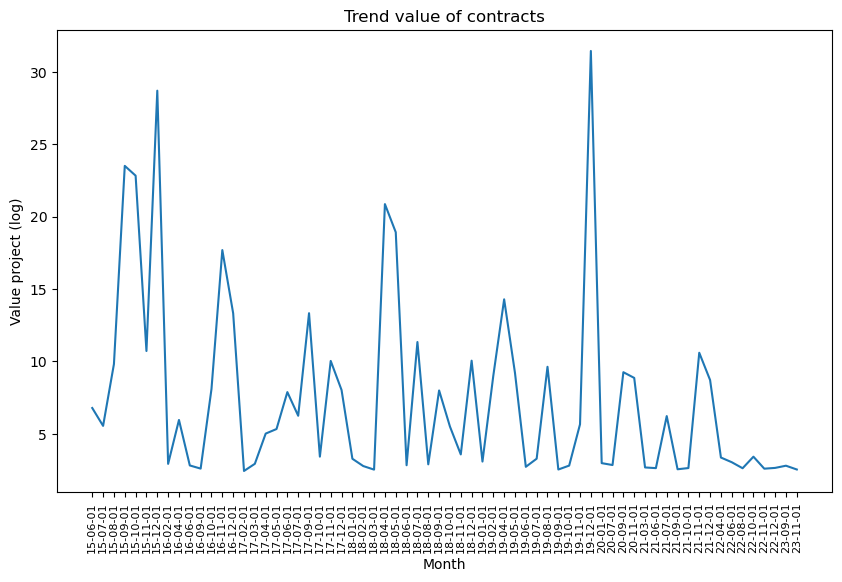

In [164]:

procesos_secop_i_data['CONTRCT_MONTH_AT'] = procesos_secop_i_data['CONTRACT_DATE'].dt.to_period('M').dt.strftime('%y-%m-01')

summary_series = procesos_secop_i_data.groupby('CONTRCT_MONTH_AT')[['CONTRACT_VALUE_LOGNORM']].sum().reset_index()

# Initialize the plot
plt.figure(figsize=(10, 6))

# Create the time series plot
sns.lineplot(data=summary_series, x='CONTRCT_MONTH_AT', y='CONTRACT_VALUE_LOGNORM')

# Rotate the x-axis labels
plt.xticks(rotation=90, fontsize=8)

# Set title and labels
plt.title('Trend value of contracts')
plt.xlabel('Month')
plt.ylabel('Value project (log)')

# Show the plot
plt.show()

#### Detail for each adition type

In [165]:
procesos_secop_i_data.groupby(['YEAR', 'HAVE_DEVIATION_COST']).apply(summary)

unique contracts  value norm avg  \
YEAR HAVE_DEVIATION_COST                                     
2015 False                            30.0     1930.597117   
     True                              6.0     1310.670495   
2016 False                             9.0      955.681134   
     True                              9.0     3135.281370   
2017 False                            16.0      643.528289   
     True                              7.0     3262.550884   
2018 False                            20.0     1229.424484   
     True                             11.0     1917.383126   
2019 False                            22.0     1923.195834   
     True                              9.0     1592.349430   
2020 False                             6.0      990.840660   
     True                              2.0     1079.393084   
2021 False                            10.0     6454.503692   
     True                              2.0      646.805194   
2022 False                             4.0     1651.227640   
     True                              2.0      414.210240   
2023 False                             2.0      496.181689   

                          cost deviation (%)  time duration avg  \
YEAR HAVE_DEVIATION_COST                                          
2015 False                          0.000000          89.833333   
     True                          20.536564         115.000000   
2016 False                          0.000000          83.333333   
     True                          37.627384         110.000000   
2017 False                          0.000000          81.875000   
     True                          19.475168         111.428571   
2018 False                          0.000000         135.000000   
     True                          24.476771         130.909091   
2019 False                          0.000000         141.863636   
     True                          14.040341         114.444444   
2020 False                          0.000000         100.666667   
     True                          11.060094         135.000000   
2021 False                          0.000000          87.000000   
     True                          20.393429          60.000000   
2022 False                          0.000000         157.500000   
     True                          13.667214         120.000000   
2023 False                          0.000000          67.000000   

                          time deviation (%)  
YEAR HAVE_DEVIATION_COST                      
2015 False                         21.203704  
     True                          13.888889  
2016 False                         20.740741  
     True                          60.061728  
2017 False                          4.017857  
     True                          87.222222  
2018 False                          4.166667  
     True                          73.156566  
2019 False                         12.083333  
     True                          77.021605  
2020 False                         35.064935  
     True                          19.444444  
2021 False                         16.222222  
     True                          81.111111  
2022 False                          6.190476  
     True                          22.222222  
2023 False                          0.000000

In [166]:
procesos_secop_i_data.groupby(['YEAR', 'HAVE_DEVIATION_TIME']).apply(summary)

unique contracts  value norm avg  \
YEAR HAVE_DEVIATION_TIME                                     
2015 False                            29.0     1679.639619   
     True                              7.0     2438.912503   
2016 False                             9.0     1026.761163   
     True                              9.0     3064.201341   
2017 False                            16.0      499.401923   
     True                              7.0     3591.982577   
2018 False                            22.0     1172.304409   
     True                              9.0     2209.889674   
2019 False                            16.0     1818.431239   
     True                             15.0     1836.436893   
2020 False                             4.0      869.094777   
     True                              4.0     1156.862755   
2021 False                             8.0     7895.846442   
     True                              4.0      667.968941   
2022 False                             2.0     1400.688547   
     True                              4.0     1157.988487   
2023 False                             2.0      496.181689   

                          cost deviation (%)  time duration avg  \
YEAR HAVE_DEVIATION_TIME                                          
2015 False                          1.874539          94.310345   
     True                           9.836822          92.857143   
2016 False                          6.214656          93.333333   
     True                          31.412728         100.000000   
2017 False                          0.804229          82.812500   
     True                          17.636929         109.285714   
2018 False                          3.665250         132.272727   
     True                          20.956554         136.666667   
2019 False                          0.000000         142.562500   
     True                           8.424204         124.666667   
2020 False                          0.000000          73.750000   
     True                           5.530047         144.750000   
2021 False                          0.000000          88.125000   
     True                          10.196715          71.250000   
2022 False                          0.000000         150.000000   
     True                           6.833607         142.500000   
2023 False                          0.000000          67.000000   

                          time deviation (%)  
YEAR HAVE_DEVIATION_TIME                      
2015 False                          0.000000  
     True                         102.777778  
2016 False                          0.000000  
     True                          80.802469  
2017 False                          0.000000  
     True                          96.405896  
2018 False                          0.000000  
     True                          98.672840  
2019 False                          0.000000  
     True                          63.935185  
2020 False                          0.000000  
     True                          62.319625  
2021 False                          0.000000  
     True                          81.111111  
2022 False                          0.000000  
     True                          17.301587  
2023 False                          0.000000

# Entity version

### Punishment last year

In [167]:
ids_entidad = list(set(procesos_secop_i_data['NIT_ENTIDAD']))

ids_entidad = parse_to_list(ids_entidad)

# Get data
query = get_query('bin/queries', 'request_punishment_entity.sql')
query = query.format(NIT_ENTIDAD_LIST = ids_entidad)


temp_punishment_data = etl.extract_data(query, id_data=SECOPI_PUNISHMENT_API, api_key=None)
temp_punishment_data['PENALTY_DATE'] = pd.to_datetime(temp_punishment_data['PENALTY_DATE'])

temp_punishment_data.head()

El numero de contratos extraidos: 530


,PENALTY_ID,NIT_ENTIDAD,PENALTY_VALUE,PENALTY_DATE
0,147-2020,800100532-8,1658082,2021-05-06
1,SIN NUMERO,800100134-1,74000000,2016-07-13
2,06-334-2015,890204646-3,999055,2017-12-18
3,06-045-2019,890204646-3,15903790,2019-06-26
4,ACTA CONJUNTA 088 DE 2015,890204646-3,1564734671,2020-12-11


In [168]:
# entidad
temp_punishment_entidad_data = pd.merge(procesos_secop_i_data[['CONTRACT_ID','NIT_ENTIDAD','CONTRACT_DATE','END_DATE']], temp_punishment_data, 
                                    how='inner', on='NIT_ENTIDAD')

def penalty_summary(x,pref):
    data = {}

    data['NUM_PENALTIES' + pref] = x['PENALTY_ID'].size
    #data['VAL_PENALTIES'] = x['PENALTY_VALUE'].sum()
    return pd.Series(data)

temp_punishment_entidad_last = temp_punishment_entidad_data[(temp_punishment_entidad_data['CONTRACT_DATE'] > temp_punishment_entidad_data['PENALTY_DATE']) &
                                                            (temp_punishment_entidad_data['PENALTY_DATE'] > (temp_punishment_entidad_data['CONTRACT_DATE'] - pd.DateOffset(years=1)))]\
                                                                .drop_duplicates().groupby('CONTRACT_ID').apply(penalty_summary, '_ENTIDAD_LAST_Y')

procesos_secop_i_data.reset_index(drop = True, inplace = True)
temp_punishment_entidad_last.reset_index(inplace = True)

procesos_secop_i_data = pd.merge(procesos_secop_i_data, 
                                 temp_punishment_entidad_last, 
                                 how='left', on='CONTRACT_ID')

procesos_secop_i_data['NUM_PENALTIES_ENTIDAD_LAST_Y'] = procesos_secop_i_data['NUM_PENALTIES_ENTIDAD_LAST_Y'].fillna(0)

In [169]:
def summary_punishment(x):
    data = {}
    data['unique contracts'] = x['CONTRACT_ID'].size
    data['value average'] = x['CONTRACT_VALUE_NORM'].mean()
    data['cost deviation'] = x['COST_DEVIATION_NORM'].mean()
    data['time deviation'] = x['TIME_DEVIATION'].mean()
    data['avg penalties to entity last year'] = x['NUM_PENALTIES_ENTIDAD_LAST_Y'].mean()
    data['var penalties to entity last year'] = x['NUM_PENALTIES_ENTIDAD_LAST_Y'].std()

    return pd.Series(data)

procesos_secop_i_data.groupby('HAVE_DEVIATION').apply(summary_punishment)

,unique contracts,value average,cost deviation,time deviation,avg penalties to entity last year,var penalties to entity last year
HAVE_DEVIATION,,,,,,
False,97.0,1881.950384,0.000000,0.000000,4.886598,17.069024
True,70.0,1969.643567,0.154863,0.658789,5.500000,16.465819


### Time or cost deviation in the past year

In [170]:
# Get data
ids_entidad = list(set(procesos_secop_i_data['NIT_ENTIDAD']))

batch = 1

split_list = len(ids_entidad) // batch

temp_adition_historical = pd.DataFrame()

for i in range(batch):
    starts = (i*split_list)
    ends = (i+1)*split_list

    if i == (batch - 1):
        list_entidades = parse_to_list(ids_entidad[starts:])
    else:
        list_entidades = parse_to_list(ids_entidad[starts:ends])

    query = get_query('bin/queries', 'request_historical_data_si_entity.sql')
    query = query.format(NIT_ENTIDAD_LIST = list_entidades)

    temp_adition_historical_batch = etl.extract_data(query, id_data=SECOPI_PROCESS_API)

    temp_adition_historical = pd.concat([temp_adition_historical, temp_adition_historical_batch])

def currency_standarize(df, cuantia_col):

    salario_minimo = {2012:566664,
                        2013:589000,
                        2014:616000, 
                        2015:644350,
                        2016:689455,
                        2017:737717,
                        2018:781242,
                        2019:828116,
                        2020:877803,
                        2021:908526,
                        2022:1000000,
                        2023:1160000,
                        2024:1300000}
        
    for col in cuantia_col:
        temp = [val/salario_minimo[anno] for val,anno in zip(df[col],df['YEAR_AT'])]
        df[col.replace("_ORIG", "_NORM")] = temp
        del temp
    
    return df

interested_col = ['YEAR_AT', 'SUM_ESTIMATED_COST_ORIG', 'SUM_CONTRACT_VALUE_ORIG']

for col in interested_col:
    temp_adition_historical[col] = pd.to_numeric(temp_adition_historical[col])

temp_adition_historical = currency_standarize(temp_adition_historical, ['SUM_ESTIMATED_COST_ORIG', 'SUM_CONTRACT_VALUE_ORIG'])

temp_adition_historical.head(10)

El numero de contratos extraidos: 8136


,NIT_ENTIDAD,MONTH_AT,YEAR_AT,PROJECTS,PROJECTS_W_BOTH_ADITION,SUM_ESTIMATED_COST_ORIG,SUM_CONTRACT_VALUE_ORIG,SUM_ORIGINAL_DEADLINE,SUM_ESTIMATED_COST_NORM,SUM_CONTRACT_VALUE_NORM
0,591500887-4,2013-04-01T00:00:00.000,2013,1,0,3000000,3000000,30,5.093379,5.093379
1,591500887-4,2013-05-01T00:00:00.000,2013,1,0,14691324,13100004,12,24.942825,22.241093
2,591500887-4,2013-08-01T00:00:00.000,2013,1,0,54366489,53540358,60,92.303037,90.900438
3,591500887-4,2013-09-01T00:00:00.000,2013,1,0,12600237,12600237,24,21.392593,21.392593
4,591500887-4,2013-11-01T00:00:00.000,2013,3,0,1049235879,1048602123,81,1781.385194,1780.309207
5,591500887-4,2013-12-01T00:00:00.000,2013,2,0,19482956,19335800,10,33.078024,32.828183
6,591500887-4,2014-03-01T00:00:00.000,2014,1,0,129372276,129105100,90,210.019929,209.586201
7,591500887-4,2014-08-01T00:00:00.000,2014,2,0,432664652,419891006,180,702.377682,681.641244
8,591500887-4,2014-09-01T00:00:00.000,2014,2,0,67245294,66849379,69,109.164438,108.521719
9,591500887-4,2014-10-01T00:00:00.000,2014,2,0,10687602,10687602,17,17.350003,17.350003


In [171]:
temp_adition_historical['MONTH_AT'] = pd.to_datetime(temp_adition_historical['MONTH_AT'])
procesos_secop_i_data['CONTRACT_DATE'] = pd.to_datetime(procesos_secop_i_data['CONTRACT_DATE'])

merged_df = pd.merge(procesos_secop_i_data, temp_adition_historical, how='inner', on='NIT_ENTIDAD',
                     left_index=False, right_index=False, sort=False)

# Filter the merged DataFrame to include only rows where the date falls within the range of stated_at and ended_at columns
merged_df = merged_df[(merged_df['MONTH_AT'] >= (merged_df['CONTRACT_DATE'] - pd.DateOffset(months=12))) & 
                      (merged_df['MONTH_AT'] < merged_df['CONTRACT_DATE'])]

def proportion_cost_adition(x):
    data = {}

    # Convert columns to numeric data types
    x['PROJECTS_W_BOTH_ADITION'] = pd.to_numeric(x['PROJECTS_W_BOTH_ADITION'], errors='coerce')
    x['PROJECTS'] = pd.to_numeric(x['PROJECTS'], errors='coerce')

    # Sum of 'PROJECTS_W_BOTH_ADITION' and 'PROJECTS'
    contracts_w_deviations = x['PROJECTS_W_BOTH_ADITION'].sum()
    total_contracts = x['PROJECTS'].sum()

    # Check for division by zero
    if total_contracts != 0:
        proportion = contracts_w_deviations / total_contracts
    else:
        proportion = None



    # Calculate award growth
    #df['AWARD_GROWTH_NORM'] = ((df['CONTRACT_VALUE_NORM'] - df['ESTIMATED_COST_NORM'])/df['ESTIMATED_COST_NORM'])
    

    # data['deviations'] = contracts_w_deviations
    data['TOTAL_CONTRACTS_OBRAS'] = total_contracts
    data['PROPORTION_DEVIATIONS_ENTIDAD_LAST_Y'] = proportion

    data['PROJECT_INTENSITY_NORM_LAST_Y'] = x['SUM_ESTIMATED_COST_NORM'].sum()/x['SUM_CONTRACT_VALUE_NORM'].sum()
    data['AWARD_GROWTH_ORIG_LAST_Y'] = ((x['SUM_CONTRACT_VALUE_NORM'].sum() - x['SUM_ESTIMATED_COST_NORM'].sum())/x['SUM_ESTIMATED_COST_NORM'].sum())

    return pd.Series(data)

merged_df = merged_df.groupby('CONTRACT_ID').apply(proportion_cost_adition)

merged_df = merged_df.reset_index()
merged_df.head()

procesos_secop_i_data = pd.merge(procesos_secop_i_data, 
                                 merged_df, 
                                 how='left', on='CONTRACT_ID')

In [172]:
def summary_deviation(x):
    data = {}
    data['unique contracts'] = x['CONTRACT_ID'].size
    data['unique entities'] = x['NIT_ENTIDAD'].drop_duplicates().size
    data['value average'] = x['CONTRACT_VALUE_NORM'].mean()
    data['cost deviation'] = x['COST_DEVIATION_NORM'].mean()
    data['time deviation'] = x['TIME_DEVIATION'].mean()
    data['avg deviation to entity last year'] = x['PROPORTION_DEVIATIONS_ENTIDAD_LAST_Y'].mean()
    data['avg project intensity last year'] = x['PROJECT_INTENSITY_NORM_LAST_Y'].mean()
    data['avg award growth last year'] = x['AWARD_GROWTH_ORIG_LAST_Y'].mean()
    #data['var deviation to entity last year'] = x['PROPORTION_DEVIATIONS_ENTIDAD_LAST_Y'].std()

    return pd.Series(data)

procesos_secop_i_data.groupby('HAVE_DEVIATION').apply(summary_deviation)

,unique contracts,unique entities,value average,cost deviation,time deviation,avg deviation to entity last year,avg project intensity last year,avg award growth last year
HAVE_DEVIATION,,,,,,,,
False,97.0,73.0,1881.950384,0.000000,0.000000,0.203124,1.041375,0.238715
True,70.0,51.0,1969.643567,0.154863,0.658789,0.377691,1.075312,-0.014442


## Supplier version

### Punishment last year

In [173]:
supplier_data = pd.read_csv(get_path('data', 'suppliers_list_secop_standarized.csv'))


ids_contratistas = list(set(supplier_data['id_contratista_other_versions']))
names_contratistas = list(set(supplier_data['nom_contratista_other_versions']))

ids_contratistas = parse_to_list(ids_contratistas)
names_contratistas = parse_to_list(names_contratistas)

# Get data
query = get_query('bin/queries', 'request_punishment_supplier.sql')
query = query.format(ID_CONTRATISTA = ids_contratistas, NAME_CONTRATISTA = names_contratistas)


# temp_punishment_data = etl.extract_data(query, id_data=SECOPI_PUNISHMENT_API, api_key=None)
# temp_punishment_data['PENALTY_DATE'] = pd.to_datetime(temp_punishment_data['PENALTY_DATE'])

#temp_punishment_data.head()

### Time or cost deviation in the past year

In [174]:
supplier_data = pd.read_csv(get_path('data', 'suppliers_list_secop_standarized.csv'))

# supplier_data['key_others_version'] = supplier_data['id_contratista_other_versions']

ids_contratistas = list(set(supplier_data['id_contratista_other_versions']))
names_contratistas = list(set(supplier_data['nom_contratista_other_versions']))

list_contratistas_ids = parse_to_list(ids_contratistas)

list_contratistas_names = parse_to_list(names_contratistas)

query = get_query('bin/queries', 'request_historical_data_si_supplier.sql')
query = query.format(ID_CONTRATISTA = list_contratistas_ids, NAME_CONTRATISTA = list_contratistas_names)

temp_adition_historical_supplier = etl.extract_data(query, id_data=SECOPI_PROCESS_API)

# temp_adition_historical_supplier = pd.concat([temp_adition_historical_supplier, temp_adition_historical_supplier_batch])

temp_adition_historical_supplier.head()

El numero de contratos extraidos: 2326


,ID_CONTRATISTA_NET,NAME_CONTRATISTA_NET,MONTH_AT,YEAR_AT,PROJECTS,PROJECTS_W_BOTH_ADITION,SUM_ESTIMATED_COST_ORIG,SUM_CONTRACT_VALUE_ORIG,SUM_ORIGINAL_DEADLINE
0,1014858 de Barbosa Santander,GEIMAR SUAREZ TAVERA,2015-09-01T00:00:00.000,2015,1,0,181500000,181479239,75
1,10543754,BLANDON ALZATE FRANCISCO JAVIER,2013-08-01T00:00:00.000,2013,1,0,191608408,187785843,90
2,10543754,BLANDON ALZATE FRANCISCO JAVIER,2014-12-01T00:00:00.000,2014,2,1,703006344,701079988,145
3,10543754,FRANCISCO JAVIER BLANDN ALZATE,2017-11-01T00:00:00.000,2017,2,0,109026309,109026307,65
4,10543754,FRANCISCO JAVIER BLANDON,2015-12-01T00:00:00.000,2015,1,0,18000000,17999976,8


In [175]:
temp_adition_historical_supplier['MONTH_AT'] = pd.to_datetime(temp_adition_historical_supplier['MONTH_AT'])

interested_col = ['PROJECTS', 'PROJECTS_W_BOTH_ADITION', 'SUM_ESTIMATED_COST_ORIG', 'SUM_CONTRACT_VALUE_ORIG', 'SUM_ORIGINAL_DEADLINE']

for col in interested_col:
    temp_adition_historical_supplier[col] = pd.to_numeric(temp_adition_historical_supplier[col])


merged_df = pd.merge(supplier_data, temp_adition_historical_supplier, how='inner', 
                     left_on=['id_contratista_other_versions', 'nom_contratista_other_versions'], 
                     right_on=['ID_CONTRATISTA_NET', 'NAME_CONTRATISTA_NET'],
                     left_index=False, right_index=False, sort=False)

def summary_cont_hist(x):
    data = {}
    data['PROJECTS'] = x['PROJECTS'].sum()
    data['PROJECTS_W_BOTH_ADITION'] = x['PROJECTS_W_BOTH_ADITION'].sum()
    data['SUM_ESTIMATED_COST_ORIG'] = x['SUM_ESTIMATED_COST_ORIG'].sum()
    data['SUM_CONTRACT_VALUE_ORIG'] = x['SUM_CONTRACT_VALUE_ORIG'].sum()
    data['SUM_ORIGINAL_DEADLINE'] = x['SUM_ORIGINAL_DEADLINE'].sum()

    return pd.Series(data)

merged_df = merged_df.groupby(['ID_CONTRATISTA', 'NOM_CONTRATISTA', 'MONTH_AT']).apply(summary_cont_hist).reset_index()


merged_df = pd.merge(procesos_secop_i_data, merged_df, how='inner', 
                     left_on=['ID_CONTRATISTA', 'NOM_CONTRATISTA'], 
                     right_on=['ID_CONTRATISTA', 'NOM_CONTRATISTA'],
                     left_index=False, right_index=False, sort=False)

# Filter the merged DataFrame to include only rows where the date falls within the range of stated_at and ended_at columns
merged_df = merged_df[(merged_df['MONTH_AT'] >= (merged_df['CONTRACT_DATE'] - pd.DateOffset(months=12))) & 
                      (merged_df['MONTH_AT'] < merged_df['CONTRACT_DATE'])]

def proportion_cost_adition(x):
    data = {}

    # Convert columns to numeric data types
    x['PROJECTS_W_BOTH_ADITION'] = pd.to_numeric(x['PROJECTS_W_BOTH_ADITION'], errors='coerce')
    x['PROJECTS'] = pd.to_numeric(x['PROJECTS'], errors='coerce')

    # Sum of 'PROJECTS_W_BOTH_ADITION' and 'PROJECTS'
    contracts_w_deviations = x['PROJECTS_W_BOTH_ADITION'].sum()
    total_contracts = x['PROJECTS'].sum()

    # Check for division by zero
    if total_contracts != 0:
        proportion = contracts_w_deviations / total_contracts
    else:
        proportion = None



    # Calculate award growth
    #df['AWARD_GROWTH_NORM'] = ((df['CONTRACT_VALUE_NORM'] - df['ESTIMATED_COST_NORM'])/df['ESTIMATED_COST_NORM'])
    

    # data['deviations'] = contracts_w_deviations
    data['TOTAL_CONTRACTS_OBRAS_CONT'] = total_contracts
    data['PROPORTION_DEVIATIONS_CONT_LAST_Y'] = proportion

    data['PROJECT_INTENSITY_NORM_CONT_LAST_Y'] = x['SUM_ESTIMATED_COST_ORIG'].sum()/x['SUM_CONTRACT_VALUE_ORIG'].sum()
    data['AWARD_GROWTH_ORIG_LAST_CONT_Y'] = ((x['SUM_CONTRACT_VALUE_ORIG'].sum() - x['SUM_ESTIMATED_COST_ORIG'].sum())/x['SUM_ESTIMATED_COST_ORIG'].sum())

    return pd.Series(data)

merged_df = merged_df.groupby('CONTRACT_ID').apply(proportion_cost_adition)

merged_df = merged_df.reset_index()
merged_df.head()

,CONTRACT_ID,TOTAL_CONTRACTS_OBRAS_CONT,PROPORTION_DEVIATIONS_CONT_LAST_Y,PROJECT_INTENSITY_NORM_CONT_LAST_Y,AWARD_GROWTH_ORIG_LAST_CONT_Y
0,15-1-138089-3735561,2.0,0.500,1.000004,-0.000004
1,15-1-138416-3768277,8.0,0.375,1.004778,-0.004755
2,15-1-138758-3764902,1.0,1.000,1.000534,-0.000534
3,15-1-139262-3824587,1.0,1.000,1.002664,-0.002657
4,15-1-139495-3883849,1.0,1.000,1.000841,-0.000841


In [176]:
procesos_secop_i_data = pd.merge(procesos_secop_i_data, 
                                 merged_df, 
                                 how='left', on='CONTRACT_ID')

def summary_deviation(x):
    data = {}
    data['unique contracts'] = x['CONTRACT_ID'].size
    data['value average'] = x['CONTRACT_VALUE_NORM'].mean()
    data['cost deviation'] = x['COST_DEVIATION_NORM'].mean()
    data['time deviation'] = x['TIME_DEVIATION'].mean()
    data['avg deviation to entity last year'] = x['PROPORTION_DEVIATIONS_CONT_LAST_Y'].mean()
    data['var deviation to entity last year'] = x['PROPORTION_DEVIATIONS_CONT_LAST_Y'].std()

    return pd.Series(data)

procesos_secop_i_data.groupby('HAVE_DEVIATION').apply(summary_deviation)

,unique contracts,value average,cost deviation,time deviation,avg deviation to entity last year,var deviation to entity last year
HAVE_DEVIATION,,,,,,
False,97.0,1881.950384,0.000000,0.000000,0.056924,0.139238
True,70.0,1969.643567,0.154863,0.658789,0.839058,0.291840


In [179]:
def summary_deviation_suppliers(x):
    data = {}
    data['unique contracts'] = x['CONTRACT_ID'].size
    data['unique suppliers'] = x['ID_CONTRATISTA'].drop_duplicates().size
    data['value average'] = x['CONTRACT_VALUE_NORM'].mean()
    data['cost deviation'] = x['COST_DEVIATION_NORM'].mean()
    data['time deviation'] = x['TIME_DEVIATION'].mean()
    data['avg deviation to supplier last year'] = x['PROPORTION_DEVIATIONS_CONT_LAST_Y'].mean()
    data['avg project intensity last year'] = x['PROJECT_INTENSITY_NORM_CONT_LAST_Y'].mean()
    data['avg award growth last year'] = x['AWARD_GROWTH_ORIG_LAST_CONT_Y'].mean()
    #data['var deviation to entity last year'] = x['PROPORTION_DEVIATIONS_ENTIDAD_LAST_Y'].std()

    return pd.Series(data)

procesos_secop_i_data.groupby('HAVE_DEVIATION').apply(summary_deviation_suppliers)

,unique contracts,unique suppliers,value average,cost deviation,time deviation,avg deviation to supplier last year,avg project intensity last year,avg award growth last year
HAVE_DEVIATION,,,,,,,,
False,97.0,94.0,1881.950384,0.000000,0.000000,0.056924,1.027821,0.481636
True,70.0,70.0,1969.643567,0.154863,0.658789,0.839058,1.039425,0.024067


## Special visualization

In [184]:
location_data = pd.read_csv(get_path('data', 'location_contracts.csv'))

interested_col = ['ruta_web', 'latitud', 'longitud', 'categoria_munp_ent', 
                  'codigo_municipio_ent', 'codigo_departamento_ent']
location_data = location_data[interested_col].drop_duplicates()

procesos_secop_i_data_loc = pd.merge(procesos_secop_i_data, location_data, how='left', 
                left_on='URLPROCESO', 
                right_on='ruta_web',
                left_index=False, right_index=False, sort=False)

def summary_loc(x):
    data = {}
    data['unique contracts'] = x['CONTRACT_ID'].size
    data['latitud'] = x['latitud'].mean()
    data['longitud'] = x['longitud'].mean()
    data['value'] = x['PROPORTION_DEVIATIONS_CONT_LAST_Y'].mean()
    data['min'] = x['PROPORTION_DEVIATIONS_CONT_LAST_Y'].min()
    data['max'] = x['PROPORTION_DEVIATIONS_CONT_LAST_Y'].max()
    return pd.Series(data)

procesos_secop_i_data_loc = procesos_secop_i_data_loc.groupby('codigo_municipio_ent').apply(summary_loc).reset_index()

import folium

# Create a folium map centered at an average location
folium_map = folium.Map(location=[4.5709, -74.2973], zoom_start=6)

# Add circles to the map
for idx, row in procesos_secop_i_data_loc.iterrows():
    folium.Circle(
        location=(row['latitud'], row['longitud']),
        radius=row['value']*40000,  # Radius in meters, adjust as needed
        color='',
        fill=True,
        fill_color='blue',
        fill_opacity=0.5  # Adjust the opacity as needed
    ).add_to(folium_map)

# Save the map to an HTML file
folium_map.save('map.html')

# Display the map in a Jupyter Notebook (if using Jupyter)
folium_map

In [189]:
procesos_secop_i_data_loc['value'].min()

0.0

## Variables during project

### First addition time

In [ ]:
ids = list(set(procesos_secop_i_data['ID_ADJUDICACION']))

ids = parse_to_list(ids)

query = get_query('bin/queries', 'request_first_adding_date.sql').format(LIST_UID = ids)

temp_additions_data = etl.extract_data(query, id_data=SECOPI_ADDITIONS_API, api_key=None)

temp_additions_data.head()

El numero de contratos extraidos: 70


,ID_ADJUDICACION,NUM_ADDITION,NUM_ADDITION_VALUE,NUM_ADDITION_TIME,FIRST_ADDITION_AT,FIRST_ADDITION_TIME_AT,FIRST_ADDITION_VALUE_AT
0,10285913,1,0,1,2021-08-25T00:00:00.000,2021-08-25T00:00:00.000,NaN
1,10296834,2,0,2,2020-12-23T00:00:00.000,2020-12-23T00:00:00.000,NaN
2,10326352,1,1,1,2021-10-15T00:00:00.000,2021-10-15T00:00:00.000,2021-10-15T00:00:00.000
3,10502654,3,1,3,2020-07-17T00:00:00.000,2020-07-17T00:00:00.000,2020-10-09T00:00:00.000
4,10910037,1,1,1,2021-04-16T00:00:00.000,2021-04-16T00:00:00.000,2021-04-16T00:00:00.000


In [ ]:
temp_additions_data['FIRST_ADDITION_AT'] = pd.to_datetime(temp_additions_data['FIRST_ADDITION_AT'])
procesos_secop_i_data = pd.merge(procesos_secop_i_data, temp_additions_data, 
                                    how='left', on='ID_ADJUDICACION')

procesos_secop_i_data['DAY_DIFF_FIRST_ADDITION'] = (procesos_secop_i_data['FIRST_ADDITION_AT'] - procesos_secop_i_data['START_DATE']) / np.timedelta64(1, 'D')
procesos_secop_i_data['RATIO_FIRST_ADDITION'] = procesos_secop_i_data['DAY_DIFF_FIRST_ADDITION'] / procesos_secop_i_data['ORIGINAL_DEADLINE']

bins = [0, 0.25, 0.5, 0.75, 1, float('inf')]  # Define your bin edges
labels = ['very early', 'early', 'medium', 'late', 'very late']  # Assign labels to bins

# Create a new categorical column based on the bins
procesos_secop_i_data['FIRST_ADITION_TIME_GROUP'] = pd.cut(procesos_secop_i_data['RATIO_FIRST_ADDITION'], bins=bins, labels=labels, right=False)

procesos_secop_i_data['FIRST_ADITION_TIME_GROUP'] = procesos_secop_i_data['FIRST_ADITION_TIME_GROUP'].cat.add_categories('NA').fillna('NA')

procesos_secop_i_data[['URLPROCESO','START_DATE', 'ORIGINAL_DEADLINE', 'FIRST_ADDITION_AT', 'DAY_DIFF_FIRST_ADDITION', 'FIRST_ADITION_TIME_GROUP']].head(5)

,URLPROCESO,START_DATE,ORIGINAL_DEADLINE,FIRST_ADDITION_AT,DAY_DIFF_FIRST_ADDITION,FIRST_ADITION_TIME_GROUP
0,{'url': 'https://www.contratos.gov.co/consultas/detalleProceso.do?numConstancia=17-1-182595'},2017-12-27,90.0,NaT,NaN,NA
1,{'url': 'https://www.contratos.gov.co/consultas/detalleProceso.do?numConstancia=15-1-138089'},2015-07-06,120.0,2015-10-27,113.0,late
2,{'url': 'https://www.contratos.gov.co/consultas/detalleProceso.do?numConstancia=15-1-141972'},2015-08-07,120.0,2015-11-24,109.0,late
3,{'url': 'https://www.contratos.gov.co/consultas/detalleProceso.do?numConstancia=15-1-143842'},2015-09-17,90.0,NaT,NaN,NA
4,{'url': 'https://www.contratos.gov.co/consultas/detalleProceso.do?numConstancia=19-1-202937'},2019-09-16,90.0,2019-09-06,-10.0,NA


In [ ]:
procesos_secop_i_data[procesos_secop_i_data['HAVE_DEVIATION']].groupby(['FIRST_ADITION_TIME_GROUP']).apply(summary)

C:\Users\nicolas.arrieta\AppData\Local\Temp\ipykernel_16536\3803707511.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  procesos_secop_i_data[procesos_secop_i_data['HAVE_DEVIATION']].groupby(['FIRST_ADITION_TIME_GROUP']).apply(summary)


,unique contracts,value norm avg,cost deviation (%),time duration avg,time deviation (%),Project intensity norm avg
FIRST_ADITION_TIME_GROUP,,,,,,
very early,2.0,453.679272,22.327991,120.000000,37.777778,3.851164
early,2.0,493.250134,13.700542,120.000000,6.666667,4.527996
medium,2.0,1049.806568,47.716720,135.000000,25.000000,7.008888
late,13.0,1494.166619,6.594305,98.769231,95.994561,15.896891
very late,50.0,2263.250557,16.216491,117.000000,63.160714,15.580498
NA,1.0,1294.883879,20.000000,90.000000,66.666667,14.387599


In [ ]:
#procesos_secop_i_data['NUM_ADDITION'] = procesos_secop_i_data['NUM_ADDITION'].astype(int)
procesos_secop_i_data.groupby('NUM_ADDITION').apply(summary).sort_values(by='NUM_ADDITION', ascending=True)

,unique contracts,value norm avg,cost deviation (%),time duration avg,time deviation (%),Project intensity norm avg
NUM_ADDITION,,,,,,
1,44.0,1126.577650,14.883256,103.068182,35.520382,11.077178
2,11.0,3777.298722,17.400038,161.272727,83.208219,17.684825
3,9.0,1834.653255,7.749638,88.333333,112.716049,19.642013
4,3.0,2075.909810,23.680671,110.000000,174.814815,22.430624
5,2.0,9158.565884,46.656664,180.000000,250.000000,36.595172
6,1.0,5698.606692,3.675276,180.000000,94.444444,31.658926


### Punishment during the project

In [ ]:
# entidad
temp_punishment_entidad_active = temp_punishment_entidad_data[(temp_punishment_entidad_data['END_DATE'] > temp_punishment_entidad_data['PENALTY_DATE']) &
                                                            (temp_punishment_entidad_data['PENALTY_DATE'] > temp_punishment_entidad_data['CONTRACT_DATE'])]\
                                                                .drop_duplicates().groupby('CONTRACT_ID').apply(penalty_summary, '_ENTIDAD_ACTIVE')

#union new rows
procesos_secop_i_data.reset_index(drop = True, inplace = True)
temp_punishment_entidad_active.reset_index(inplace = True)

procesos_secop_i_data = pd.merge(procesos_secop_i_data, 
                                 temp_punishment_entidad_active, 
                                 how='left', on='CONTRACT_ID')

def summary_punishment_v2(x):
    data = {}
    data['unique contracts'] = x['CONTRACT_ID'].size
    data['value average'] = x['CONTRACT_VALUE_NORM'].mean()
    data['cost deviation'] = x['COST_DEVIATION_NORM'].mean()
    data['time deviation'] = x['TIME_DEVIATION'].mean()
    data['avg penalties to entity during project'] = x['NUM_PENALTIES_ENTIDAD_ACTIVE'].mean()
    data['var penalties to entity during project'] = x['NUM_PENALTIES_ENTIDAD_ACTIVE'].std()

    return pd.Series(data)

procesos_secop_i_data.groupby('HAVE_DEVIATION').apply(summary_punishment_v2)

,unique contracts,value average,cost deviation,time deviation,avg penalties to entity during project,var penalties to entity during project
HAVE_DEVIATION,,,,,,
False,97.0,1881.950384,0.000000,0.000000,20.000000,13.820275
True,70.0,1969.643567,0.154863,0.658789,18.333333,10.559356


In [ ]:
procesos_secop_i_data.to_csv(get_path('data', 'collected_obra_data_v3.csv'), index=False)